# Filtered Data

In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
import PIL
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model 1 (Original)

In [3]:
# 데이터셋 디렉터리 경로
dataset_dir = '/content/drive/MyDrive/dataset_real'
# train_dir = os.path.join(dataset_dir, 'train')
# val_dir = os.path.join(dataset_dir, 'val')

# 사진 크기
image_height = 224
image_width = 224
batch_size = 32



train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)



# 훈련셋에서 배치를 생성
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 1006 files belonging to 4 classes.
Using 805 files for training.
Found 1006 files belonging to 4 classes.
Using 201 files for validation.
(32, 224, 224, 3)
(32,)


In [4]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [5]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [6]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 513   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [8]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 132s 5s/step - loss: 29.3424 - mae: 4.6580 - val_loss: 22.3973 - val_mae: 3.8884
Epoch 2/10
26/26 [==============================] - 9s 328ms/step - loss: 19.9976 - mae: 3.7229 - val_loss: 16.5574 - val_mae: 3.3031
Epoch 3/10
26/26 [==============================] - 9s 329ms/step - loss: 15.0749 - mae: 3.1919 - val_loss: 13.6439 - val_mae: 3.0044
Epoch 4/10
26/26 [==============================] - 9s 330ms/step - loss: 12.7043 - mae: 2.8937 - val_loss: 12.1790 - val_mae: 2.8391
Epoch 5/10
26/26 [==============================] - 9s 326ms/step - loss: 11.4183 - mae: 2.7140 - val_loss: 11.2529 - val_mae: 2.7248
Epoch 6/10
26/26 [==============================] - 9s 329ms/step - loss: 10.4604 - mae: 2.5812 - val_loss: 10.4693 - val_mae: 2.6311
Epoch 7/10
26/26 [==============================] - 9s 323ms/step - loss: 9.6248 - mae: 2.4663 - val_loss: 9.7660 - val_mae: 2.5479
Epoch 8/10
26/26 [==============================] - 9s 324ms/step

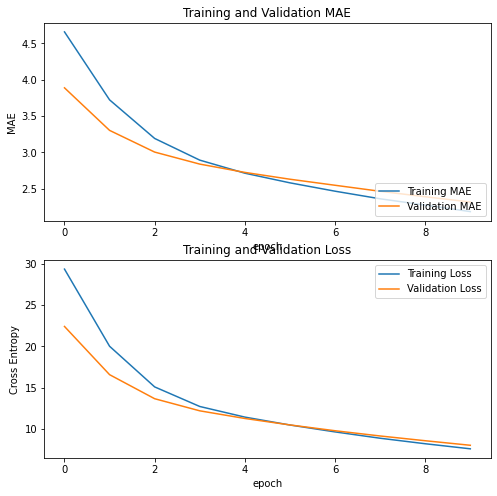

In [9]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

# Model 2 (Filtered Data 1)

In [10]:
# 데이터셋 디렉터리 경로
dataset_dir = '/content/drive/MyDrive/dataset_real_filtered'
# train_dir = os.path.join(dataset_dir, 'train')
# val_dir = os.path.join(dataset_dir, 'val')

# 사진 크기
image_height = 224
image_width = 224
batch_size = 32



train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)



# 훈련셋에서 배치를 생성
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 1006 files belonging to 4 classes.
Using 805 files for training.
Found 1006 files belonging to 4 classes.
Using 201 files for validation.
(32, 224, 224, 3)
(32,)


In [11]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [13]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [15]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 180s 7s/step - loss: 24.2020 - mae: 3.9967 - val_loss: 16.7336 - val_mae: 3.2213
Epoch 2/10
26/26 [==============================] - 9s 327ms/step - loss: 18.0663 - mae: 3.3529 - val_loss: 15.0172 - val_mae: 3.0331
Epoch 3/10
26/26 [==============================] - 9s 327ms/step - loss: 16.5380 - mae: 3.1897 - val_loss: 14.0520 - val_mae: 2.9375
Epoch 4/10
26/26 [==============================] - 9s 328ms/step - loss: 15.4839 - mae: 3.0923 - val_loss: 13.2536 - val_mae: 2.8570
Epoch 5/10
26/26 [==============================] - 9s 328ms/step - loss: 14.5544 - mae: 2.9974 - val_loss: 12.6104 - val_mae: 2.7924
Epoch 6/10
26/26 [==============================] - 9s 330ms/step - loss: 13.6662 - mae: 2.9087 - val_loss: 11.8146 - val_mae: 2.7041
Epoch 7/10
26/26 [==============================] - 9s 326ms/step - loss: 12.8685 - mae: 2.8235 - val_loss: 11.4085 - val_mae: 2.6684
Epoch 8/10
26/26 [==============================] - 9s 325ms/st

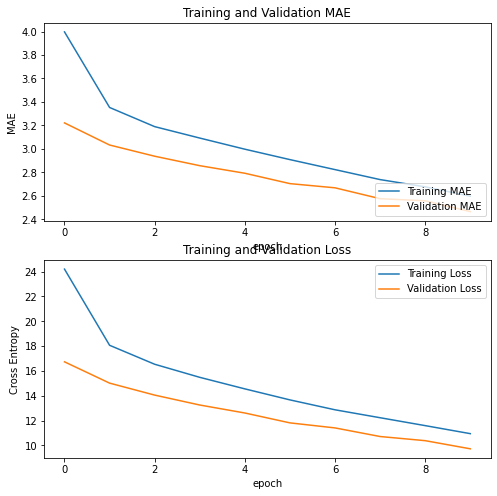

In [16]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

# Model 3 (Filtered Data 2)

In [17]:
# 데이터셋 디렉터리 경로
dataset_dir = '/content/drive/MyDrive/dataset_real_filtered2'
# train_dir = os.path.join(dataset_dir, 'train')
# val_dir = os.path.join(dataset_dir, 'val')

# 사진 크기
image_height = 224
image_width = 224
batch_size = 32



train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)



# 훈련셋에서 배치를 생성
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 1006 files belonging to 4 classes.
Using 805 files for training.
Found 1006 files belonging to 4 classes.
Using 201 files for validation.
(32, 224, 224, 3)
(32,)


In [18]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [20]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [22]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 183s 7s/step - loss: 21.9539 - mae: 3.7769 - val_loss: 22.5852 - val_mae: 3.8076
Epoch 2/10
26/26 [==============================] - 9s 328ms/step - loss: 20.1814 - mae: 3.6316 - val_loss: 20.4905 - val_mae: 3.6189
Epoch 3/10
26/26 [==============================] - 9s 329ms/step - loss: 18.7823 - mae: 3.4985 - val_loss: 18.8704 - val_mae: 3.4707
Epoch 4/10
26/26 [==============================] - 9s 327ms/step - loss: 17.3518 - mae: 3.3608 - val_loss: 17.5459 - val_mae: 3.3429
Epoch 5/10
26/26 [==============================] - 9s 329ms/step - loss: 16.1095 - mae: 3.2399 - val_loss: 16.1053 - val_mae: 3.1966
Epoch 6/10
26/26 [==============================] - 9s 329ms/step - loss: 15.1118 - mae: 3.1342 - val_loss: 15.0575 - val_mae: 3.0814
Epoch 7/10
26/26 [==============================] - 9s 329ms/step - loss: 14.0286 - mae: 3.0220 - val_loss: 14.1224 - val_mae: 2.9756
Epoch 8/10
26/26 [==============================] - 9s 327ms/st

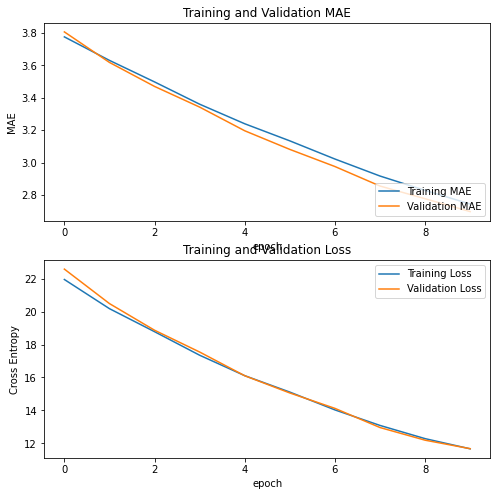

In [23]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()